# The topic of my project is visualizing the fate of Sun-like stars in M31 throughout the course of the merger

# Question I'm answering: How can I center a visualization of the merger on the Milky Way? What criteria should I use to select solar analogs? How do I differentiate the solar analogs from other disk particles?



# Plots to make
# a) Plot of all 3 galaxies centered on the MW (x: Position (kpc), y: Position (kpc), disk particles, all snapshots; visualize merger from MW perspective -> highlights fate of solar analogs in context of merger)

# b) Like plot above, but with solar analogs color-coated

# c) Histogram of solar analog distance from center of M31 (x: Distance (kpc), y: Number of analogs, solar analogs from disk particles, test with first snapshot and some snapshot after pass-by; quantitatively describe fate of Sun-like stars in M31 -> shows distribution as time passes)

# d) Phase diagram (v_component vs. x) of entire galay and solar analogs (x: x position (kpc), y: v_component of particles, qualtitaively show how motion of analogs changes at each snapshot -> shows if they remain on circular orbits or not)



# START OF CODE
# 1) Important relevant modules and scripts

In [1]:
# ASTR 400B Project

# Import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# Import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# My modules
from ReadFile import Read
from CenterOfMass2 import CenterOfMass
from MassProfile import MassProfile
from OrbitCOM import VectorDiff
from RotateFrame import RotateFrame

# 2) Class with built-in functions to follow fate of Sun-like stars in galaxy within Local Group

In [16]:
# Class for determining fate of a galaxy's solar analogs
class Fate:
    
    # Initialize the instance of this Class with the following properties:
    def __init__(self, galaxy, starting_snap, axis, ptype=2):
        
        # Define galaxy name
        self.galaxy = galaxy
        
        # Define filename of first snapshot
        self.starting_snap = starting_snap
        self.file1 = 'C:/Users/Jimmy/Downloads/{0}/{0}_{1}.txt'.format(self.galaxy,self.starting_snap)
        
        # Define velocity component to plot phase diagram of
        self.axis = axis
        
        # Define filenames for/extract data from MW and M31 Orbit COM text files
        self.MWCOM = 'C:/Users/Jimmy/400B_Lilly/Research Assignments/5/Orbit_MW.txt'
        self.dataMWCOM = np.genfromtxt(self.MWCOM,dtype=None,names=True)
        self.M31COM = 'C:/Users/Jimmy/400B_Lilly/Research Assignments/5/Orbit_M31.txt'
        self.dataM31COM = np.genfromtxt(self.M31COM,dtype=None,names=True)
        
        # Define position of Sun w.r.t to center of the MW
        self.rSun = 8.178 # Distance of Sun from center of the MW (currently 8.178 kpc from GRAVITY collaboration)
        
        # Generate array of radii from 0 to Sun's position
        self.radii = np.arange(0,self.rSun,0.001)
        
        # Calculate circular velocity enclosed with Sun's position
        self.MP = MassProfile(self.galaxy,210)
        self.velocities = self.MP.CircularVelocityTotal(self.radii)
        
        # Extract circular velocity at Sun's position
        self.vcirc = self.velocities[len(self.velocities)-1].value
        #self.v = 239 # v: Local Standard of Rest velocity of Sun (currently 239 km/s from van der marel+ 2012b)  
        print("Circular Velocity at Sun's distance in M31 = {0}".format(self.vcirc))
                
        # Define CoM object for galaxy using disk particles
        self.COMD1 = CenterOfMass(self.file1,2)

        # Find CoM components for position and velocity of host galaxy
        self.COMP1 = self.COMD1.COM_P(0.1,2)
        self.COMV1 = self.COMD1.COM_V(self.COMP1[0],self.COMP1[1],self.COMP1[2])

        # Adjust disk particle positions w.r.t. CoM of host galaxy
        self.xD_1 = self.COMD1.x - self.COMP1[0].value
        self.yD_1 = self.COMD1.y - self.COMP1[1].value
        self.zD_1 = self.COMD1.z - self.COMP1[2].value

        # Adjust disk particle velocities w.r.t. CoM of host galaxy
        self.vxD_1 = self.COMD1.vx - self.COMV1[0].value
        self.vyD_1 = self.COMD1.vy - self.COMV1[1].value
        self.vzD_1 = self.COMD1.vz - self.COMV1[2].value

        # Calculate disk particle distances and velocities to center of host galaxy
        self.R = np.sqrt(self.xD_1**2+self.yD_1**2+self.zD_1**2)
        self.V = np.sqrt(self.vxD_1**2+self.vyD_1**2)#+self.vzD_1**2)
        
        # Select particles within 10% of Sun's distance & v_circ, also v_z < |30| km/s 
        self.candidates = np.where((self.R <= 1.1*self.rSun) & (self.R >= 0.9*self.rSun) & \
                                   (self.V <= 1.1*self.vcirc) & (self.V >= 0.9*self.vcirc) & \
                                   (np.abs(self.vzD_1) < 30))
        print('There are {0} Sun-like stars in {1}'.format(len(self.R[self.candidates]),self.galaxy))
        
    # Function to identify solar analogs
    # Should be run only called once at end of code --> candidates will have same indices throughout simulation
    def FirstLook(self,save=False):
        # Inputs:
        #     save: boolean to determine if plot should be saved or not
        # Returns:
        #     3 plots in 1 row (histogram of candidate positions, visualization of candidates, phase diagram)
        
        # Create subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
        
        # Calculate percentage of Sun-like stars in M31 that are beyond and within the current Sun distance
        partIn = self.R[np.where(self.R<self.rSun)]
        partOut = self.R[np.where(self.R>self.rSun)]
        PercentIn = np.around((len(partIn)/len(self.R))*100,2)
        PercentOut = np.around((len(partOut)/len(self.R))*100,2)
        
        # Find time of first snapshot in Gyr
        snap_time = (self.starting_snap/70)*u.Gyr
        
        # Save percentages and snapshot time in string to print on plot
        stats = ('{0} Gyr from now'+'\n'+'% In = {1}'+'\n'+'% Out = {2}').format(snap_time,PercentIn,PercentOut)
        
        ####### HISTOGRAM OF DISTANCE FROM CENTER ########
        # Plot histogram of candidate distances from center of galaxy
        ax1.axvline(x=self.rSun,color='red',linestyle='dashed')
        
        # Overplot vertical line of current position of Sun in the MW (from GRAVITY collaboration)
        ax1.hist(self.R[self.candidates])

        # Add axis labels and title to first subplot
        ax1.set_title('Solar Analogs in {0}'.format(self.galaxy), fontsize=22)
        ax1.set_xlabel('Distance from Center of {} (kpc)'.format(self.galaxy), fontsize=18)
        ax1.set_ylabel('Number of Candidates', fontsize=18)
        
        # Set axis limits
        ax1.set_xlim(.9*self.rSun-.5,1.1*self.rSun+.5)
        yticks = np.arange(0,25,5)
        ax1.set_yticks(yticks)
        
        # Add textbox with important stats to first plot
        ax1.annotate(stats,xy=(.62,.8),xycoords='axes fraction',bbox=dict(boxstyle="round",fc="white"),fontsize = 12)
        ##################################################

        
        
        ####### VISUALIZING GALAXIES ########
        # Plot all disk particles
        h = ax2.hist2d(self.xD_1,self.yD_1,bins=200,norm=LogNorm(),cmap='viridis')

        # Plot colorbar of disk density
        cbar = plt.colorbar(h[3],ax=ax2)
        cbar.ax.set_ylabel('Number of Particles', fontsize=18)

        # Highlight solar analogs within disk
        ax2.scatter(self.xD_1[self.candidates],self.yD_1[self.candidates],color='red',s=10)

        # Add axs labels and title to second subplot
        ax2.set_title('Solar Analogs in {0}'.format(self.galaxy), fontsize=22)
        ax2.set_xlabel('x (kpc)', fontsize=18)
        ax2.set_ylabel('y (kpc)', fontsize=18)
        
        # Print number of Sun-like candidates on 2nd plot
        numCandidates = len(self.R[self.candidates])
        string = '{0} Sun-like Stars in {1}'.format(numCandidates,self.galaxy)
        ax2.annotate(string,xy=(.4,.9),xycoords='axes fraction',bbox=dict(boxstyle="round",fc="white"),fontsize = 12)

        # Adjust tick label font size
        label_size = 22
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size

        # Set axis limits
        ax2.set_xlim(-40,40)
        ax2.set_ylim(-40,40)
        ##################################################
        
        
        
        ####### PHASE DIAGRAM ########
        # Vectors for r and v 
        disk_position = np.array([self.xD_1,self.yD_1,self.zD_1]).T # transposed 
        disk_velocity = np.array([self.vxD_1,self.vyD_1,self.vzD_1]).T

        # Determine the rotated velocity vectors
        rnew, vnew = RotateFrame(disk_position,disk_velocity)
        r_analogs = rnew[self.candidates]
        v_analogs = vnew[self.candidates]

        # Plot 2D Histogram one component of  Pos vs Vel 
        ax3.hist2d(rnew[:,0],vnew[:,self.axis],bins=200,cmap='bone',norm=LogNorm())
        ax3.scatter(r_analogs[:,0],v_analogs[:,self.axis],color='red',s=50)

        # Overplot Circular Velocity from the MassProfile Code
        ax3.plot(self.radii,self.velocities,color='blue',linewidth=5)
        ax3.plot(-self.radii,-self.velocities,color='blue',linewidth=5)

        # Add x-axis label
        ax3.set_xlabel('x (kpc)', fontsize=18)
        
        # Determine which velocity component is being displayed (based on user 'axis' input)
        if self.axis == 0:
                component = 'x'
        elif self.axis == 1:
            component = 'y'
        elif self.axis == 2:
            component = 'z'
        else:
            print('Only accepted inputs are: 1 (x), 2 (y), 3(z)')

        # Add y-axis label and title (writes correct velocity component)
        ax3.set_ylabel(r'v$_%s$ (km s$^{-1}$)'%component, fontsize=18)
        ax3.set_title(r'Phase Diagram of %s (v$_%s$ vs. x)'%(self.galaxy,component),fontsize=22)

        #adjust tick label font size
        label_size = 22
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size
        #####################################################
        
        # Create buffer space between subplots
        plt.tight_layout()

        # Save plot of initial solar analogs (if user wants)
        if save == True:
            plt.savefig("C:/Users/Jimmy/400B_Lilly/Research Assignments/6/M31_candidates.png")
        
    # Plot later visualizations of solar candidates
    def Tracking(self,start,end,increment):
        # Inputs:
        #      start: snapshot to begin tracking candidates at
        #      end: snapshot to stop tracking candidates at
        #      increment: how many snapshots to skip before plotting next set of results
        # Returns:
        #      3 plots in 1 row (histogram of candidate positions, visualization of candidates, phase diagram)
                
        snap_ids = np.arange(start,end,increment)
        
        # Loop over set of snapshot numbers (snap_id) and keep track of iterations (i)
        for i, snap_id in enumerate(snap_ids):
        
            # Compose the data filename (be careful about the folder)
            # Add string of filenumber to value 000
            ilbl = '000' + str(snap_id)

            # Remove all but last 3 digits of string
            ilbl = ilbl[-3:]

            # Assign filename based on snapshot and galaxy inputs
            MW_file = 'C:/Users/Jimmy/Downloads/MW/MW_' + ilbl + '.txt'
            M31_file = 'C:/Users/Jimmy/Downloads/M31/M31_' + ilbl + '.txt'
            M33_file = 'C:/Users/Jimmy/Downloads/M33/M33_' + ilbl + '.txt'

            # Define CoM object for each galaxy using disk particles (2)
            COMD_MW = CenterOfMass(MW_file,2)
            COMD_M31 = CenterOfMass(M31_file,2)
            COMD_M33 = CenterOfMass(M33_file,2)

            # Find CoM components for position and velocity of the MW
            COMP_MW = COMD_MW.COM_P(0.1,2)
            COMV_MW = COMD_MW.COM_V(COMP_MW[0],COMP_MW[1],COMP_MW[2])
            
            # Find CoM components for position and velocity of M31
            COMP_M31 = COMD_M31.COM_P(0.1,2)
            COMV_M31 = COMD_M31.COM_V(COMP_M31[0],COMP_M31[1],COMP_M31[2])

            # Find CoM components for position and velocity of M33
            COMP_M33 = COMD_M33.COM_P(0.1,2)
            COMV_M33 = COMD_M33.COM_V(COMP_M33[0],COMP_M33[1],COMP_M33[2])
            
            # Define positions of MW Disk Particles w.r.t the MW
            xD_MW = COMD_MW.x - COMP_MW[0].value
            yD_MW = COMD_MW.y - COMP_MW[1].value
            zD_MW = COMD_MW.z - COMP_MW[2].value

            # Define positions of M31 Disk Particles w.r.t the MW
            xD_M31 = COMD_M31.x - COMP_MW[0].value
            yD_M31 = COMD_M31.y - COMP_MW[1].value
            zD_M31 = COMD_M31.z - COMP_MW[2].value
            
            # Define positions of M33 Disk Particles w.r.t the MW
            xD_M33 = COMD_M33.x - COMP_MW[0].value
            yD_M33 = COMD_M33.y - COMP_MW[1].value
            zD_M33 = COMD_M33.z - COMP_MW[2].value
            
            # Extract relative separation and velocity of MW and M31 throughout simulation
            time, MW_M31_diffP, MW_M31_diffV = VectorDiff(self.dataMWCOM,self.dataM31COM)
            
            # Define disk particle position and velocity components w.r.t CoM of respective galaxy
            if self.galaxy == 'M31':
                xD = COMD_M31.x - COMP_M31[0].value
                yD = COMD_M31.y - COMP_M31[1].value
                zD = COMD_M31.z - COMP_M31[2].value
                vxD = COMD_M31.vx - COMV_M31[0].value
                vyD = COMD_M31.vy - COMV_M31[1].value
                vzD = COMD_M31.vz - COMV_M31[2].value
            elif self.galaxy == 'M33':
                xD = COMD_M33.x - COMP_M33[0].value
                yD = COMD_M33.y - COMP_M33[1].value
                zD = COMD_M33.z - COMP_M33[2].value
                vxD = COMD_M33.vx - COMV_M33[0].value
                vyD = COMD_M33.vy - COMV_M33[1].value
                vzD = COMD_M33.vz - COMV_M33[2].value
            elif self.galaxy == 'MW':
                xD = COMD_MW.x - COMP_MW[0].value
                yD = COMD_MW.y - COMP_MW[1].value
                zD = COMD_MW.z - COMP_MW[2].value
                vxD = COMD_MW.vx - COMV_MW[0].value
                vyD = COMD_MW.vy - COMV_MW[1].value
                vzD = COMD_MW.vz - COMV_MW[2].value
            
            # Define distance of disk particles from center of galaxy of interest
            R = np.sqrt(xD**2+yD**2+zD**2)
            
            # Calculate percentage of Sun-like stars in M31 that are beyond and within the current Sun distance
            partIn = R[np.where(R<self.rSun)]
            partOut = R[np.where(R>self.rSun)]
            PercentIn = np.around((len(partIn)/len(R))*100,2)
            PercentOut = np.around((len(partOut)/len(R))*100,2)
            stats = ('{0} Gyr from now'+'\n'+'% In = {1}'+'\n'+'% Out = {2}').format(time[snap_id],PercentIn,PercentOut)
            
            # Create subplots
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
            
            ####### HISTOGRAM OF DISTANCE FROM CENTER ########
            
            # Plot histogram of candidate distances from center of galaxy
            ax1.axvline(x=self.rSun,color='red',linestyle='dashed',label='Current Solar Position')
            
            # Overplot vertical lineof current position of Sun in the MW (from GRAVITY collaboration)
            ax1.hist(R[self.candidates],bins=20)
            
            # Add axes labels and titles to first subplot
            ax1.set_title('Solar Analogs in {0}'.format(self.galaxy), fontsize=22)
            ax1.set_xlabel('Distance from Center of {} (kpc)'.format(self.galaxy), fontsize=18)
            ax1.set_ylabel('Number of Candidates', fontsize=18)
            ax1.annotate(stats,xy=(.62,.8),xycoords='axes fraction',bbox=dict(boxstyle="round",fc="white"),fontsize = 12)
            ax1.set_ylim(0,20)
            ##################################################
            
            
            
            ####### VISUALIZING GALAXIES ########
            # Plot all disk particles
            h1 = ax2.hist2d(xD_MW,yD_MW,bins=200,norm=LogNorm(),cmap='viridis')
            h2 = ax2.hist2d(xD_M31,yD_M31,bins=200,norm=LogNorm(),cmap='viridis')
            h3 = ax2.hist2d(xD_M33,yD_M33,bins=200,norm=LogNorm(),cmap='viridis')
            
            # Plot colorbar of disk density
            cbar = plt.colorbar(h1[3],ax=ax2)
            cbar.ax.set_ylabel('Number of Particles', fontsize=18)

            # Highlight solar analogs within disk as points
            ax2.scatter(xD_M31[self.candidates],yD_M31[self.candidates],color='red',s=10)

            # Add axes labels and titles to second subplot
            ax2.set_title('LG in {0} Gyr'.format(time[snap_id]), fontsize=22)
            ax2.set_xlabel('x (kpc)', fontsize=18)
            ax2.set_ylabel('y (kpc)', fontsize=18)
            
            # Set axis limits
            ax2.set_xlim(-200,200)
            ax2.set_ylim(-200,200)

            # Adjust tick label font size
            label_size = 22
            matplotlib.rcParams['xtick.labelsize'] = label_size 
            matplotlib.rcParams['ytick.labelsize'] = label_size
            ##################################################
            
            
            
            ####### PHASE DIAGRAM ########
            # Vectors for relevant disk particle positions and velocities
            disk_position = np.array([xD,yD,zD]).T # transposed 
            disk_velocity = np.array([vxD,vyD,vzD]).T
            
            # Determine the rotated position and velocity vectors
            rnew, vnew = RotateFrame(disk_position,disk_velocity)
            # Determine the rotated position and velocity vectors of solar candidates
            r_analogs = rnew[self.candidates]
            v_analogs = vnew[self.candidates]
            
            # Plot 2D Histogram one component ofPos vs Vel 
            ax3.hist2d(rnew[:,0],vnew[:,self.axis],bins=200,cmap='bone',norm=LogNorm())
            ax3.scatter(r_analogs[:,0],v_analogs[:,self.axis],color='red',s=50)

            # Overplot Circular Velocity from the MassProfile Code
            ax3.plot(self.radii,self.velocities,color='blue',linewidth=5)
            ax3.plot(-self.radii,-self.velocities,color='blue',linewidth=5)

            # Add axis labels and title
            ax3.set_xlabel('x (kpc)', fontsize=18)
            
            # Determine which velocity component is being displayed (based on user 'axis' input)
            if self.axis == 0:
                component = 'x'
            elif self.axis == 1:
                component = 'y'
            elif self.axis == 2:
                component = 'z'
            else:
                print('Only accepted inputs are: 1 (x), 2 (y), 3(z)')
            
            ax3.set_ylabel(r'v$_%s$ (km s$^{-1}$)'%component, fontsize=18)
            ax3.set_title(r'Phase Diagram of %s (v$_%s$ vs. x)'%(self.galaxy,component),fontsize=22)
            
            # Set axis limits
            ax3.set_xlim(-60,60)
            ax3.set_ylim(-400,400)

            #adjust tick label font size
            label_size = 22
            matplotlib.rcParams['xtick.labelsize'] = label_size 
            matplotlib.rcParams['ytick.labelsize'] = label_size
            #####################################################
            
            # Create buffer space between subplots
            plt.tight_layout()
            
            # Save image to a file
            #plt.savefig('G:/My Drive/Spring 2020/ASTR 400B/Final Plots/{0}_{1}.png'.format(self.galaxy,ilbl), rasterized=True, dpi=200)


# 3) Initialize an instance of the class and run FirstLook to view initial information about solar candidates

Circular Velocity at Sun's distance in M31 = 228.07
There are 73 Sun-like stars in M31


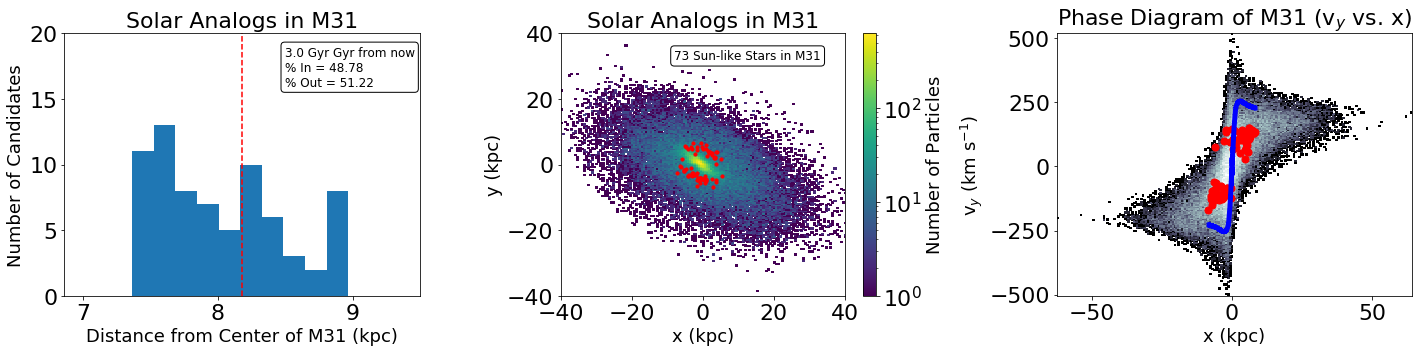

In [17]:
M31 = Fate('M31',210,1)
M31.FirstLook()

# 5) Track Sun-like stars at key times in the LG merger (as presented in van der Marel+ 2012b
# 210 (start), 277 (1st MW-M31 pericenter), 312 (just before MW-M31 pericenter), 420 (2nd MW-M31 pericenter), 446 (0.1 Gyr after merger), 800 (end of simulation)

In [15]:
# Visualize plots for important times (pericenter, apocenter, beginning, end, etc.)
important_times = [3.00,3.97,4.47,6.01,6.38,(800/70)] # in Gyr
important_snaps = [int(value*70) for value in important_times] # convert times to snap_ids

# Track solar candidates in important snaps
for snap in important_snaps:
    #M31.Tracking(snap,snap+1,1)

[210, 277, 312, 420, 446, 700]


# 6) Track Sun-like stars throught simulation

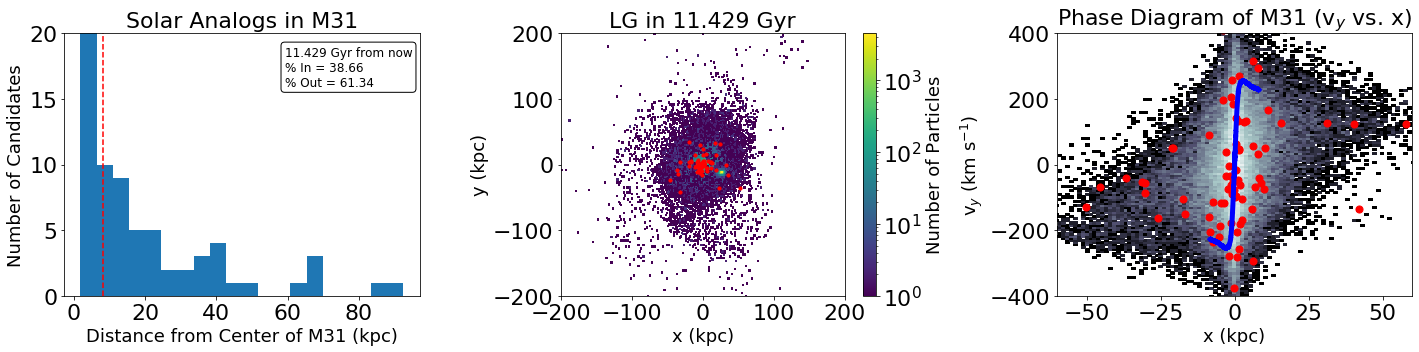

In [18]:
# Save plots for every snap
M31.Tracking(800,801,1)